In [269]:
import datetime
from datetime import date
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.stats import norm
from scipy.interpolate import interp1d
from shapely.geometry import Point
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [270]:
SWE_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Case_study/classification/SWE_CaSR-Land2_1_BowR.nc'
P_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Case_study/classification/daily_precipitation_RDRS.nc'
Bow_at_Banff = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Bow_at_Banff/basins_testcases.shp'
output_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/classification/CaSR_SWE/'

In [271]:
# open the shapefile
basin = gpd.read_file(Bow_at_Banff)

#select 05BB001 basin
basin = basin[basin['Station_ID'] == '05BB001']

# Display the basin shapefile
display(basin)



,Station_ID,Station_Na,Area_km2,Source,geometry
0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT,"POLYGON ((-115.83512 51.07677, -115.83524 51.0..."


In [272]:
# open precipitation data
P = xr.open_dataset(P_path)
P_data = P.to_dataframe()

display(P_data)

,coordinate_id,lon,lat,daily_precipitation
time,,,,
1980-01-01,1,-115.625092,50.972343,0.254825
1980-01-02,1,-115.625092,50.972343,0.362730
1980-01-03,1,-115.625092,50.972343,1.083391
1980-01-04,1,-115.625092,50.972343,0.093789
1980-01-05,1,-115.625092,50.972343,0.339676
...,...,...,...,...
2018-12-27,21,-116.337173,51.672558,0.101965
2018-12-28,21,-116.337173,51.672558,0.621428
2018-12-29,21,-116.337173,51.672558,1.788441


In [301]:
# save the precipitation data for coordinate_id 1
P_data = P_data[P_data['coordinate_id'] == 1].to_csv(output_path + 'P_basin_grid1.csv', index=False)

In [273]:
# daily mean precipitation
P_daily = P_data.groupby(['time']).mean()
P_daily = P_daily.reset_index()

# remove coordinate_id column
P_daily = P_daily.drop(columns=['coordinate_id'])
# Display the daily mean precipitation
display(P_daily)

,time,lon,lat,daily_precipitation
0,1980-01-01,-115.99698,51.352911,0.174075
1,1980-01-02,-115.99698,51.352911,0.553970
2,1980-01-03,-115.99698,51.352911,2.351273
3,1980-01-04,-115.99698,51.352911,0.784659
4,1980-01-05,-115.99698,51.352911,0.507873
...,...,...,...,...
14240,2018-12-27,-115.99698,51.352911,0.195098
14241,2018-12-28,-115.99698,51.352911,0.552746
14242,2018-12-29,-115.99698,51.352911,1.812934
14243,2018-12-30,-115.99698,51.352911,3.048324


In [274]:
# P data to geodataframe
P_data = P_data.reset_index()
geometry = [Point(xy) for xy in zip(P_data['lon'], P_data['lat'])]
P_data = P_data.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
P_data = gpd.GeoDataFrame(P_data, crs=crs, geometry=geometry)

# Display the precipitation data
display(P_data) 

,time,coordinate_id,daily_precipitation,geometry
0,1980-01-01,1,0.254825,POINT (-115.62509 50.97234)
1,1980-01-02,1,0.362730,POINT (-115.62509 50.97234)
2,1980-01-03,1,1.083391,POINT (-115.62509 50.97234)
3,1980-01-04,1,0.093789,POINT (-115.62509 50.97234)
4,1980-01-05,1,0.339676,POINT (-115.62509 50.97234)
...,...,...,...,...
299140,2018-12-27,21,0.101965,POINT (-116.33717 51.67256)
299141,2018-12-28,21,0.621428,POINT (-116.33717 51.67256)
299142,2018-12-29,21,1.788441,POINT (-116.33717 51.67256)
299143,2018-12-30,21,4.915802,POINT (-116.33717 51.67256)


In [275]:
# open SWE data
SWE = xr.open_dataset(SWE_path)
SWE_data = SWE.to_dataframe()

display(SWE_data)

lat         lon        SWE
rlat rlon time                                                 
NaN  NaN  1980-01-02 12:00:00  50.227730  244.046783  94.572525
          1980-01-03 12:00:00  50.227730  244.046783  94.465157
          1980-01-04 12:00:00  50.227730  244.046783  94.020584
          1980-01-05 12:00:00  50.227730  244.046783  94.678619
          1980-01-06 12:00:00  50.227730  244.046783  95.555687
...                                  ...         ...        ...
          2017-12-28 12:00:00  52.375286  245.581329  30.510096
          2017-12-29 12:00:00  52.375286  245.581329  33.443588
          2017-12-30 12:00:00  52.375286  245.581329  33.952774
          2017-12-31 12:00:00  52.375286  245.581329  34.283833
          2018-01-01 12:00:00  52.375286  245.581329  34.914970

[5274400 rows x 3 columns]

In [276]:
SWE_data = SWE_data.reset_index()

# Display the SWE GeoDataFrame
display(SWE_data)

,rlat,rlon,time,lat,lon,SWE
0,NaN,NaN,1980-01-02 12:00:00,50.227730,244.046783,94.572525
1,NaN,NaN,1980-01-03 12:00:00,50.227730,244.046783,94.465157
2,NaN,NaN,1980-01-04 12:00:00,50.227730,244.046783,94.020584
3,NaN,NaN,1980-01-05 12:00:00,50.227730,244.046783,94.678619
4,NaN,NaN,1980-01-06 12:00:00,50.227730,244.046783,95.555687
...,...,...,...,...,...,...
5274395,NaN,NaN,2017-12-28 12:00:00,52.375286,245.581329,30.510096
5274396,NaN,NaN,2017-12-29 12:00:00,52.375286,245.581329,33.443588
5274397,NaN,NaN,2017-12-30 12:00:00,52.375286,245.581329,33.952774
5274398,NaN,NaN,2017-12-31 12:00:00,52.375286,245.581329,34.283833


In [277]:
# Ensure 'time' column is present in the DataFrame
if 'time' in SWE_data.columns:
	# Keep only the date part of the 'time' column
	SWE_data['time'] = SWE_data['time'].dt.date

	# Display the updated dataframe
	display(SWE_data)
else:
	print("'time' column is not present in SWE_data")

,rlat,rlon,time,lat,lon,SWE
0,NaN,NaN,1980-01-02,50.227730,244.046783,94.572525
1,NaN,NaN,1980-01-03,50.227730,244.046783,94.465157
2,NaN,NaN,1980-01-04,50.227730,244.046783,94.020584
3,NaN,NaN,1980-01-05,50.227730,244.046783,94.678619
4,NaN,NaN,1980-01-06,50.227730,244.046783,95.555687
...,...,...,...,...,...,...
5274395,NaN,NaN,2017-12-28,52.375286,245.581329,30.510096
5274396,NaN,NaN,2017-12-29,52.375286,245.581329,33.443588
5274397,NaN,NaN,2017-12-30,52.375286,245.581329,33.952774
5274398,NaN,NaN,2017-12-31,52.375286,245.581329,34.283833


In [278]:
# convert lon to negative values
SWE_data['lon'] = SWE_data['lon']-360

display(SWE_data)

,rlat,rlon,time,lat,lon,SWE
0,NaN,NaN,1980-01-02,50.227730,-115.953217,94.572525
1,NaN,NaN,1980-01-03,50.227730,-115.953217,94.465157
2,NaN,NaN,1980-01-04,50.227730,-115.953217,94.020584
3,NaN,NaN,1980-01-05,50.227730,-115.953217,94.678619
4,NaN,NaN,1980-01-06,50.227730,-115.953217,95.555687
...,...,...,...,...,...,...
5274395,NaN,NaN,2017-12-28,52.375286,-114.418671,30.510096
5274396,NaN,NaN,2017-12-29,52.375286,-114.418671,33.443588
5274397,NaN,NaN,2017-12-30,52.375286,-114.418671,33.952774
5274398,NaN,NaN,2017-12-31,52.375286,-114.418671,34.283833


In [279]:
# Convert the SWE data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(SWE_data['lon'], SWE_data['lat'])]
crs = {'init': 'epsg:4326'}
SWE_gdf = gpd.GeoDataFrame(SWE_data, crs=crs, geometry=geometry)

print(SWE_gdf.head())

   rlat  rlon        time       lat         lon        SWE  \
0   NaN   NaN  1980-01-02  50.22773 -115.953217  94.572525   
1   NaN   NaN  1980-01-03  50.22773 -115.953217  94.465157   
2   NaN   NaN  1980-01-04  50.22773 -115.953217  94.020584   
3   NaN   NaN  1980-01-05  50.22773 -115.953217  94.678619   
4   NaN   NaN  1980-01-06  50.22773 -115.953217  95.555687   

                      geometry  
0  POINT (-115.95322 50.22773)  
1  POINT (-115.95322 50.22773)  
2  POINT (-115.95322 50.22773)  
3  POINT (-115.95322 50.22773)  
4  POINT (-115.95322 50.22773)  


In [280]:
# save to csv
SWE_gdf.to_csv(output_path + 'SWE_data.csv')

In [281]:
# select SWE data for the basin
SWE_basin = gpd.sjoin(SWE_gdf, basin, how="inner", op='intersects')

display(SWE_basin)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\2908966621.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  SWE_basin = gpd.sjoin(SWE_gdf, basin, how="inner", op='intersects')


,rlat,rlon,time,lat,lon,SWE,geometry,index_right,Station_ID,Station_Na,Area_km2,Source
1915440,NaN,NaN,1980-01-02,50.972347,-115.625092,145.514252,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
1915441,NaN,NaN,1980-01-03,50.972347,-115.625092,147.135864,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
1915442,NaN,NaN,1980-01-04,50.972347,-115.625092,146.875717,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
1915443,NaN,NaN,1980-01-05,50.972347,-115.625092,145.956879,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
1915444,NaN,NaN,1980-01-06,50.972347,-115.625092,146.863937,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
...,...,...,...,...,...,...,...,...,...,...,...,...
4275035,NaN,NaN,2017-12-28,51.672558,-116.337189,200.170135,POINT (-116.33719 51.67256),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
4275036,NaN,NaN,2017-12-29,51.672558,-116.337189,203.859009,POINT (-116.33719 51.67256),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
4275037,NaN,NaN,2017-12-30,51.672558,-116.337189,207.367249,POINT (-116.33719 51.67256),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
4275038,NaN,NaN,2017-12-31,51.672558,-116.337189,209.167236,POINT (-116.33719 51.67256),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT


In [282]:
# save to csv
SWE_basin.to_csv(output_path + 'SWE_basin.csv')

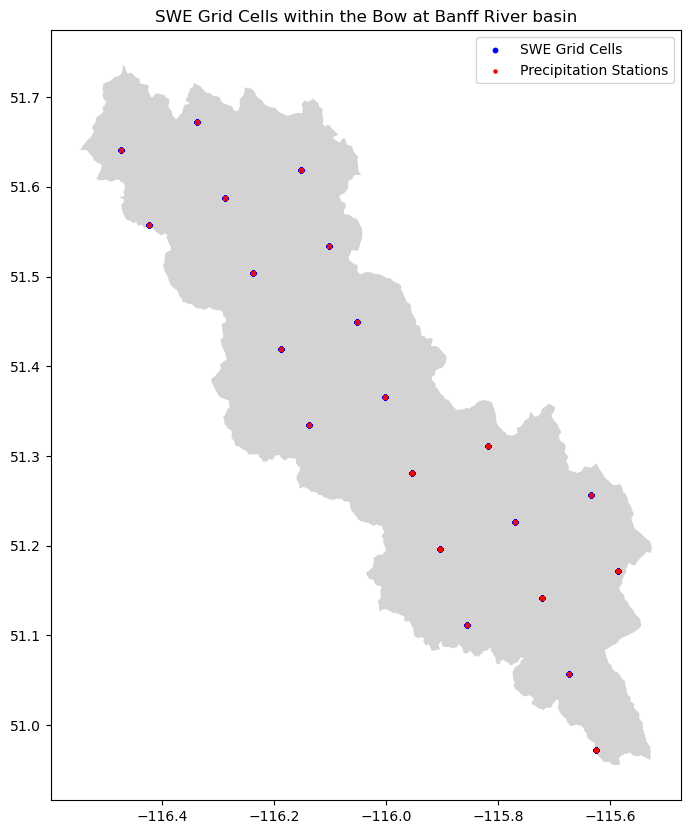

In [283]:
# Plot the stations within the study area
fig, ax = plt.subplots(figsize=(10, 10))
basin.plot(ax=ax, color='lightgrey')
SWE_basin.plot(ax=ax, color='blue', markersize=10, label='SWE Grid Cells')
P_data.plot(ax=ax, color='red', markersize=5, label='Precipitation Stations')
P_data.plot(ax=ax, color='red', markersize=5)
plt.title('SWE and Precipitation Stations within the Bow at Banff River basin')
plt.title('SWE Grid Cells within the Bow at Banff River basin')
plt.legend()
plt.show()

In [284]:
# get basin mean SWE
SWE_basin_mean = SWE_basin.groupby('time').mean()
SWE_basin_mean = SWE_basin_mean.reset_index()

display(SWE_basin_mean)

,time,rlat,rlon,lat,lon,SWE,index_right,Area_km2
0,1980-01-02,NaN,NaN,51.352908,-115.997001,145.297458,0.0,2210.56
1,1980-01-03,NaN,NaN,51.352908,-115.997001,148.070760,0.0,2210.56
2,1980-01-04,NaN,NaN,51.352908,-115.997001,148.233443,0.0,2210.56
3,1980-01-05,NaN,NaN,51.352908,-115.997001,148.978573,0.0,2210.56
4,1980-01-06,NaN,NaN,51.352908,-115.997001,149.213135,0.0,2210.56
...,...,...,...,...,...,...,...,...
13875,2017-12-28,NaN,NaN,51.352908,-115.997001,147.322401,0.0,2210.56
13876,2017-12-29,NaN,NaN,51.352908,-115.997001,152.284639,0.0,2210.56
13877,2017-12-30,NaN,NaN,51.352908,-115.997001,159.335216,0.0,2210.56
13878,2017-12-31,NaN,NaN,51.352908,-115.997001,160.474173,0.0,2210.56


Peak SWE climatologial value

In [285]:
# Reset the index to make 'time' a regular column
SWE_data_reset = SWE_basin_mean.reset_index()

# Convert 'time' column to datetime
SWE_data_reset['time'] = pd.to_datetime(SWE_data_reset['time'])

# get peak SWE for each year 1981-2010
peak_SWE = SWE_data_reset[SWE_data_reset['time'].dt.year.isin(range(1981, 2011))].groupby(
    SWE_data_reset['time'].dt.year)['SWE'].max().reset_index()

# Rename the columns for clarity
peak_SWE.columns = ['Year', 'peak_SWE']

# Display the result
display(peak_SWE)

#get average peak SWE for 1981-2010
average_peak_SWE = peak_SWE['peak_SWE'].mean()
print(average_peak_SWE)

# save the peak SWE data
peak_SWE.to_csv(output_path + 'peak_SWE.csv', index=False)

,Year,peak_SWE
0,1981,277.028751
1,1982,274.280443
2,1983,196.746325
3,1984,193.918475
4,1985,190.932394
5,1986,318.156984
6,1987,236.095692
7,1988,199.416064
8,1989,260.143244
9,1990,293.947982


247.93135218544612


In [286]:
# 5% of the average peak SWE
threshold = 0.05 * average_peak_SWE
print(threshold)

12.396567609272306


In [287]:
# Ensure 'time' column is present in SWE_data_reset
if 'time' not in SWE_data_reset.columns:
	raise KeyError("'time' column is not present in SWE_data_reset")

# select complete water year oct 1st to sept 31st next year and add a season year column
water_year = SWE_data_reset[(SWE_data_reset['time'].dt.month >= 10) | (SWE_data_reset['time'].dt.month <= 9)]
water_year['Season_year'] = water_year['time'].dt.year
water_year['Season_year'] = water_year['Season_year'].where(water_year['time'].dt.month >= 10, water_year['Season_year'] - 1)
# drop 1979
water_year = water_year[water_year['Season_year'] >= 1980]
#drop 2017
water_year = water_year[water_year['Season_year'] <= 2016]

display(water_year)

,index,time,rlat,rlon,lat,lon,SWE,index_right,Area_km2,Season_year
273,273,1980-10-01,NaN,NaN,51.352908,-115.997001,1.841673,0.0,2210.56,1980
274,274,1980-10-02,NaN,NaN,51.352908,-115.997001,1.837980,0.0,2210.56,1980
275,275,1980-10-03,NaN,NaN,51.352908,-115.997001,1.475393,0.0,2210.56,1980
276,276,1980-10-04,NaN,NaN,51.352908,-115.997001,1.090080,0.0,2210.56,1980
277,277,1980-10-05,NaN,NaN,51.352908,-115.997001,0.920324,0.0,2210.56,1980
...,...,...,...,...,...,...,...,...,...,...
13782,13782,2017-09-26,NaN,NaN,51.352908,-115.997001,6.390730,0.0,2210.56,2016
13783,13783,2017-09-27,NaN,NaN,51.352908,-115.997001,4.521327,0.0,2210.56,2016
13784,13784,2017-09-28,NaN,NaN,51.352908,-115.997001,2.615778,0.0,2210.56,2016
13785,13785,2017-09-29,NaN,NaN,51.352908,-115.997001,1.214276,0.0,2210.56,2016


In [288]:
#winter season 1st SWE non-zero day to peak SWE day
water_year['SWE_nonzero'] = water_year['SWE'] > 0
water_year['SWE_nonzero'] = water_year['SWE_nonzero'].astype(int)

# get the first day of SWE > 0
first_SWE_nonzero = water_year[water_year['SWE_nonzero'] == 1].groupby('Season_year').first().reset_index()
first_SWE_nonzero = first_SWE_nonzero[['Season_year', 'time']]
first_SWE_nonzero.columns = ['Season_year', 'First_SWE_nonzero']

# add value of SWE on the first day of SWE > 0 in next column
first_SWE_nonzero['SWE'] = first_SWE_nonzero.apply(lambda row: water_year[(water_year['Season_year'] == row['Season_year']) & (water_year['time'] == row['First_SWE_nonzero'])]['SWE'].values[0], axis=1)

# extract P values for the first day of SWE >  0 from P data
first_SWE_nonzero['P'] = pd.merge(first_SWE_nonzero, P_daily, left_on='First_SWE_nonzero', right_on='time', how='inner')['daily_precipitation']

display(first_SWE_nonzero)


,Season_year,First_SWE_nonzero,SWE,P
0,1980,1980-10-01,1.841673,0.280162
1,1981,1981-10-01,5.597688,0.346102
2,1982,1982-10-01,2.167921,0.020907
3,1983,1983-10-01,12.835852,0.003352
4,1984,1984-10-01,25.022929,0.001937
5,1985,1985-10-01,34.260075,0.595249
6,1986,1986-10-01,35.864127,3.130325
7,1987,1987-10-04,1.090756,2.250093
8,1988,1988-10-01,25.899206,0.014358
9,1989,1989-10-01,0.485707,0.777645


In [289]:
# save the first SWE non-zero day data
first_SWE_nonzero.to_csv(output_path + 'first_SWE_nonzero.csv', index=False)

# Select data for winter season: 

onset : date where SWE is 5% from peak SWE day

end : peak SWE day

In [290]:
# Initialize an empty DataFrame to store the results
onset_to_peak_SWE = pd.DataFrame()

# Iterate through each season year
for year in water_year['Season_year'].unique():
    # Filter the data for the current season year
    season_data = water_year[water_year['Season_year'] == year]
    
    # Find the onset date
    onset_date = season_data[season_data['SWE'] >= threshold]['time'].min()
    
    # Find the peak date
    peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
    
    # Select data from onset to peak
    selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
    
    # Append the selected data to the result DataFrame
    onset_to_peak_SWE = pd.concat([onset_to_peak_SWE, selected_data])

# Display the result
display(onset_to_peak_SWE)

,index,time,rlat,rlon,lat,lon,SWE,index_right,Area_km2,Season_year,SWE_nonzero
298,298,1980-10-26,NaN,NaN,51.352908,-115.997001,15.913508,0.0,2210.56,1980,1
299,299,1980-10-27,NaN,NaN,51.352908,-115.997001,16.070620,0.0,2210.56,1980,1
300,300,1980-10-28,NaN,NaN,51.352908,-115.997001,16.220521,0.0,2210.56,1980,1
301,301,1980-10-29,NaN,NaN,51.352908,-115.997001,16.268643,0.0,2210.56,1980,1
302,302,1980-10-30,NaN,NaN,51.352908,-115.997001,16.623654,0.0,2210.56,1980,1
...,...,...,...,...,...,...,...,...,...,...,...
13633,13633,2017-04-30,NaN,NaN,51.352908,-115.997001,327.561761,0.0,2210.56,2016,1
13634,13634,2017-05-01,NaN,NaN,51.352908,-115.997001,328.883358,0.0,2210.56,2016,1
13635,13635,2017-05-02,NaN,NaN,51.352908,-115.997001,330.114381,0.0,2210.56,2016,1
13636,13636,2017-05-03,NaN,NaN,51.352908,-115.997001,331.051247,0.0,2210.56,2016,1


In [291]:
# save the onset to peak SWE data
onset_to_peak_SWE.to_csv(output_path + 'onset_to_peak_SWE.csv', index=False)

In [292]:
# keep only time and SWE columns
onset_to_peak_SWE = onset_to_peak_SWE[['time', 'SWE', 'Season_year']]
onset_to_peak_SWE = onset_to_peak_SWE.reset_index()

# extract P values for the onset to peak SWE period
onset_to_peak_SWE['P'] = pd.merge(onset_to_peak_SWE, P_daily, left_on='time', right_on='time', how='inner')['daily_precipitation']

display(onset_to_peak_SWE)

,index,time,SWE,Season_year,P
0,298,1980-10-26,15.913508,1980,5.818125
1,299,1980-10-27,16.070620,1980,0.032145
2,300,1980-10-28,16.220521,1980,0.001581
3,301,1980-10-29,16.268643,1980,0.010713
4,302,1980-10-30,16.623654,1980,0.065991
...,...,...,...,...,...
7325,13633,2017-04-30,327.561761,2016,0.763412
7326,13634,2017-05-01,328.883358,2016,0.084340
7327,13635,2017-05-02,330.114381,2016,0.178592
7328,13636,2017-05-03,331.051247,2016,0.046619


In [293]:
# add cumulative P values for onset to peak SWE period
onset_to_peak_SWE['cumulative_P'] = onset_to_peak_SWE.groupby('Season_year')['P'].cumsum()

display(onset_to_peak_SWE)

,index,time,SWE,Season_year,P,cumulative_P
0,298,1980-10-26,15.913508,1980,5.818125,5.818125
1,299,1980-10-27,16.070620,1980,0.032145,5.850270
2,300,1980-10-28,16.220521,1980,0.001581,5.851851
3,301,1980-10-29,16.268643,1980,0.010713,5.862564
4,302,1980-10-30,16.623654,1980,0.065991,5.928555
...,...,...,...,...,...,...
7325,13633,2017-04-30,327.561761,2016,0.763412,291.390381
7326,13634,2017-05-01,328.883358,2016,0.084340,291.474731
7327,13635,2017-05-02,330.114381,2016,0.178592,291.653320
7328,13636,2017-05-03,331.051247,2016,0.046619,291.699921


In [344]:
# calculate mean_SWE for each season year
onset_to_peak_SWE['mean_SWE'] = onset_to_peak_SWE.groupby('Season_year')['SWE'].transform('mean')

# calculate mean_SWE for each season year and select max cumulative_P for each season year
onset_to_peak_SWE_P_mean = onset_to_peak_SWE.groupby('Season_year').agg(
    mean_SWE=('mean_SWE', 'mean'),
    mean_cumulative_P=('cumulative_P', 'mean'),
    max_SWE=('SWE', 'max'),
    max_cumulative_P=('cumulative_P', 'max')
).reset_index()

# calculate mean_SWE/max_cumulative_P ratio
onset_to_peak_SWE_P_mean['mean_SWE/max_cumulative_P'] = onset_to_peak_SWE_P_mean['mean_SWE'] / onset_to_peak_SWE_P_mean['max_cumulative_P']

display(onset_to_peak_SWE_P_mean)

,Season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,mean_SWE/max_cumulative_P
0,1980,167.937837,151.264709,277.028751,279.874084,0.600048
1,1981,138.472342,125.801987,274.280443,250.361801,0.553089
2,1982,113.922539,92.429932,196.746325,163.338806,0.697462
3,1983,108.088117,91.435417,193.918475,164.619522,0.656594
4,1984,106.491506,93.429108,190.932394,182.261307,0.584279
5,1985,174.481770,134.675095,318.156984,289.653168,0.602382
6,1986,137.222501,107.667953,236.095692,203.758194,0.673458
7,1987,99.895028,78.548309,199.416064,166.879059,0.598607
8,1988,127.944726,126.876427,260.143244,268.147186,0.477144
9,1989,185.321914,167.978821,293.947982,315.431671,0.587518


In [295]:
# save the onset to peak SWE mean P data
onset_to_peak_SWE_P_mean.to_csv(output_path + 'onset_to_peak_SWE_P_mean.csv', index=False)

# Repeat calculation for each grid cell

(Looks like error comes because taking basin mean)

In [296]:
SWE_basin_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/classification/CaSR_SWE/SWE_basin.csv'


In [297]:
# open SWE data
SWE_basin_grid = pd.read_csv(SWE_basin_path)

# keep only time, lat, lon, geometry and SWE columns
SWE_basin_grid = SWE_basin_grid[['time', 'lat', 'lon', 'SWE', 'geometry']]
SWE_basin_grid = SWE_basin_grid.reset_index()

display(SWE_basin_grid)


,index,time,lat,lon,SWE,geometry
0,0,1980-01-02,50.972347,-115.625092,145.514252,POINT (-115.62509155273438 50.972347259521484)
1,1,1980-01-03,50.972347,-115.625092,147.135864,POINT (-115.62509155273438 50.972347259521484)
2,2,1980-01-04,50.972347,-115.625092,146.875717,POINT (-115.62509155273438 50.972347259521484)
3,3,1980-01-05,50.972347,-115.625092,145.956879,POINT (-115.62509155273438 50.972347259521484)
4,4,1980-01-06,50.972347,-115.625092,146.863937,POINT (-115.62509155273438 50.972347259521484)
...,...,...,...,...,...,...
291475,291475,2017-12-28,51.672558,-116.337189,200.170135,POINT (-116.33718872070312 51.67255783081055)
291476,291476,2017-12-29,51.672558,-116.337189,203.859009,POINT (-116.33718872070312 51.67255783081055)
291477,291477,2017-12-30,51.672558,-116.337189,207.367249,POINT (-116.33718872070312 51.67255783081055)
291478,291478,2017-12-31,51.672558,-116.337189,209.167236,POINT (-116.33718872070312 51.67255783081055)


In [298]:
# Add a unique coordinate_id for each grid point
SWE_basin_grid['coordinate_id'] = SWE_basin_grid.groupby(['geometry']).ngroup()

# Display the updated dataframe
display(SWE_basin_grid)

,index,time,lat,lon,SWE,geometry,coordinate_id
0,0,1980-01-02,50.972347,-115.625092,145.514252,POINT (-115.62509155273438 50.972347259521484),1
1,1,1980-01-03,50.972347,-115.625092,147.135864,POINT (-115.62509155273438 50.972347259521484),1
2,2,1980-01-04,50.972347,-115.625092,146.875717,POINT (-115.62509155273438 50.972347259521484),1
3,3,1980-01-05,50.972347,-115.625092,145.956879,POINT (-115.62509155273438 50.972347259521484),1
4,4,1980-01-06,50.972347,-115.625092,146.863937,POINT (-115.62509155273438 50.972347259521484),1
...,...,...,...,...,...,...,...
291475,291475,2017-12-28,51.672558,-116.337189,200.170135,POINT (-116.33718872070312 51.67255783081055),18
291476,291476,2017-12-29,51.672558,-116.337189,203.859009,POINT (-116.33718872070312 51.67255783081055),18
291477,291477,2017-12-30,51.672558,-116.337189,207.367249,POINT (-116.33718872070312 51.67255783081055),18
291478,291478,2017-12-31,51.672558,-116.337189,209.167236,POINT (-116.33718872070312 51.67255783081055),18


In [299]:
# disply data for coordinate_id 1
display(SWE_basin_grid[SWE_basin_grid['coordinate_id'] == 1])

,index,time,lat,lon,SWE,geometry,coordinate_id
0,0,1980-01-02,50.972347,-115.625092,145.514252,POINT (-115.62509155273438 50.972347259521484),1
1,1,1980-01-03,50.972347,-115.625092,147.135864,POINT (-115.62509155273438 50.972347259521484),1
2,2,1980-01-04,50.972347,-115.625092,146.875717,POINT (-115.62509155273438 50.972347259521484),1
3,3,1980-01-05,50.972347,-115.625092,145.956879,POINT (-115.62509155273438 50.972347259521484),1
4,4,1980-01-06,50.972347,-115.625092,146.863937,POINT (-115.62509155273438 50.972347259521484),1
...,...,...,...,...,...,...,...
13875,13875,2017-12-28,50.972347,-115.625092,140.661499,POINT (-115.62509155273438 50.972347259521484),1
13876,13876,2017-12-29,50.972347,-115.625092,146.819580,POINT (-115.62509155273438 50.972347259521484),1
13877,13877,2017-12-30,50.972347,-115.625092,156.683624,POINT (-115.62509155273438 50.972347259521484),1
13878,13878,2017-12-31,50.972347,-115.625092,156.511551,POINT (-115.62509155273438 50.972347259521484),1


In [300]:
# save the SWE basin grid data ccordinate_id 1
SWE_basin_grid[SWE_basin_grid['coordinate_id'] == 1].to_csv(output_path + 'SWE_basin_grid1.csv', index=False)

In [ ]:
# print number of coordinate_id
print(SWE_basin_grid['coordinate_id'].nunique())

# print what coordinates are in the SWE_basin_grid
print(SWE_basin_grid['coordinate_id'].unique())

21
[ 1  3  7  4  0  8  5  2  9  6 13 10 15 11 16 12 19 17 14 20 18]


In [185]:
# Group by coordinate_id and get the unique geometry for each group
SWE_geometry_by_coordinate_id = SWE_basin_grid.groupby('coordinate_id')['geometry'].unique()

# Print the geometry coordinates for each coordinate_id
for coordinate_id, geometries in SWE_geometry_by_coordinate_id.items():
    print(f"Coordinate ID: {coordinate_id}")
    for geometry in geometries:
        print(geometry)

#save the geomery and id data
SWE_geometry_by_coordinate_id.to_csv(output_path + 'SWE_eometry_by_coordinate_id.csv')

Coordinate ID: 0
POINT (-115.58695983886719 51.17202377319336)
Coordinate ID: 1
POINT (-115.62509155273438 50.972347259521484)
Coordinate ID: 2
POINT (-115.63525390625 51.25678253173828)
Coordinate ID: 3
POINT (-115.67327880859375 51.05708694458008)
Coordinate ID: 4
POINT (-115.72161865234375 51.141815185546875)
Coordinate ID: 5
POINT (-115.7701416015625 51.22651672363281)
Coordinate ID: 6
POINT (-115.81884765625 51.31119918823242)
Coordinate ID: 7
POINT (-115.85614013671875 51.1114387512207)
Coordinate ID: 8
POINT (-115.9049072265625 51.196075439453125)
Coordinate ID: 9
POINT (-115.953857421875 51.280704498291016)
Coordinate ID: 10
POINT (-116.00296020507812 51.36530685424805)
Coordinate ID: 11
POINT (-116.05224609375 51.449893951416016)
Coordinate ID: 12
POINT (-116.10174560546875 51.53445816040039)
Coordinate ID: 13
POINT (-116.13796997070312 51.334590911865234)
Coordinate ID: 14
POINT (-116.15139770507812 51.618995666503906)
Coordinate ID: 15
POINT (-116.1875 51.41911315917969)
Coo

In [192]:
# Group by coordinate_id and get the unique geometry for each group
P_geometry_by_coordinate_id = P_data.groupby('coordinate_id')['geometry'].unique()

# Print the geometry coordinates for each coordinate_id
for coordinate_id, geometries in P_geometry_by_coordinate_id.items():
    print(f"Coordinate ID: {coordinate_id}")
    for geometry in geometries:
        print(geometry)

#save the geomery and id data
P_geometry_by_coordinate_id.to_csv(output_path + 'P_eometry_by_coordinate_id.csv')

Coordinate ID: 1
POINT (-115.62509155273438 50.97234344482422)
Coordinate ID: 2
POINT (-115.67327880859375 51.05708694458008)
Coordinate ID: 3
POINT (-115.85612487792969 51.1114387512207)
Coordinate ID: 4
POINT (-115.72161865234375 51.141815185546875)
Coordinate ID: 5
POINT (-115.58692932128906 51.172027587890625)
Coordinate ID: 6
POINT (-115.90489196777344 51.196083068847656)
Coordinate ID: 7
POINT (-115.7701416015625 51.22651672363281)
Coordinate ID: 8
POINT (-115.63522338867188 51.25679016113281)
Coordinate ID: 9
POINT (-115.95382690429688 51.28071212768555)
Coordinate ID: 10
POINT (-115.81884765625 51.31119918823242)
Coordinate ID: 11
POINT (-116.137939453125 51.334598541259766)
Coordinate ID: 12
POINT (-116.00294494628906 51.36531066894531)
Coordinate ID: 13
POINT (-116.18746948242188 51.41911697387695)
Coordinate ID: 14
POINT (-116.05223083496094 51.44990158081055)
Coordinate ID: 15
POINT (-116.2371826171875 51.50362014770508)
Coordinate ID: 16
POINT (-116.10171508789062 51.53445

In [228]:
# keep only time, coordinate_id and SWE columns
SWE_basin_grid = SWE_basin_grid[['time', 'coordinate_id', 'SWE']]
SWE_basin_grid = SWE_basin_grid.reset_index()

# strart coordinate_id from 1
SWE_basin_grid['coordinate_id'] = SWE_basin_grid['coordinate_id'] + 1

display(SWE_basin_grid)

# keep only time, coordinate_id and daily_precipitation columns
P_data = P_data[['time', 'coordinate_id', 'daily_precipitation']]
P_data = P_data.reset_index()

display(P_data)

,index,time,coordinate_id,SWE
0,0,1980-01-02,3,145.514252
1,1,1980-01-03,3,147.135864
2,2,1980-01-04,3,146.875717
3,3,1980-01-05,3,145.956879
4,4,1980-01-06,3,146.863937
...,...,...,...,...
291475,291475,2017-12-28,20,200.170135
291476,291476,2017-12-29,20,203.859009
291477,291477,2017-12-30,20,207.367249
291478,291478,2017-12-31,20,209.167236


,index,time,coordinate_id,daily_precipitation
0,0,1980-01-01,1,0.254825
1,1,1980-01-02,1,0.362730
2,2,1980-01-03,1,1.083391
3,3,1980-01-04,1,0.093789
4,4,1980-01-05,1,0.339676
...,...,...,...,...
299140,299140,2018-12-27,21,0.101965
299141,299141,2018-12-28,21,0.621428
299142,299142,2018-12-29,21,1.788441
299143,299143,2018-12-30,21,4.915802


In [229]:
# Convert the 'time' column in SWE_basin_grid to datetime
SWE_basin_grid['time'] = pd.to_datetime(SWE_basin_grid['time'])

# merge SWE and P data on time and coordinate_id
SWE_P = pd.merge(SWE_basin_grid, P_data, on=['time', 'coordinate_id'], how='inner')

display(SWE_P)

,index_x,time,coordinate_id,SWE,index_y,daily_precipitation
0,0,1980-01-02,3,145.514252,28491,0.628346
1,1,1980-01-03,3,147.135864,28492,1.133855
2,2,1980-01-04,3,146.875717,28493,0.222424
3,3,1980-01-05,3,145.956879,28494,0.263054
4,4,1980-01-06,3,146.863937,28495,0.025073
...,...,...,...,...,...,...
277595,291475,2017-12-28,20,200.170135,284531,1.617370
277596,291476,2017-12-29,20,203.859009,284532,3.375988
277597,291477,2017-12-30,20,207.367249,284533,5.024947
277598,291478,2017-12-31,20,209.167236,284534,0.055228


In [206]:
# save the SWE_P data
SWE_P.to_csv(output_path + 'SWE_P.csv', index=False)

In [266]:
# Ensure 'time' column is in datetime format
SWE_P['time'] = pd.to_datetime(SWE_P['time'])

# Define water year for each coordinate_id time series
water_year_grid = SWE_P[(SWE_P['time'].dt.month >= 10) | (SWE_P['time'].dt.month <= 9)]
water_year_grid['Season_year'] = water_year_grid['time'].dt.year
water_year_grid['Season_year'] = water_year_grid['Season_year'].where(water_year_grid['time'].dt.month >= 10, water_year_grid['Season_year'] - 1)

# drop 1979
water_year_grid = water_year_grid[water_year_grid['Season_year'] >= 1980]
#drop 2017
water_year_grid = water_year_grid[water_year_grid['Season_year'] <= 2016]
# Display the updated dataframe
display(water_year_grid)



,index_x,time,coordinate_id,SWE,index_y,daily_precipitation,Season_year
273,273,1980-10-01,3,0.659927,28764,0.148904,1980
274,274,1980-10-02,3,0.653784,28765,0.000562,1980
275,275,1980-10-03,3,0.000000,28766,0.000000,1980
276,276,1980-10-04,3,0.000000,28767,0.000000,1980
277,277,1980-10-05,3,0.000000,28768,0.001785,1980
...,...,...,...,...,...,...,...
277502,291382,2017-09-26,20,17.427170,284438,0.980653,2016
277503,291383,2017-09-27,20,15.287083,284439,0.530347,2016
277504,291384,2017-09-28,20,12.276982,284440,0.000000,2016
277505,291385,2017-09-29,20,8.637960,284441,0.000000,2016


In [267]:
# Group the data by coordinate_id
grouped = water_year_grid.groupby('coordinate_id')

# Iterate through each group and save the timeseries to a separate CSV file
for coordinate_id, group in grouped:
    # Define the file path
    file_path = os.path.join(output_path, f'SWE_timeseries_{coordinate_id}.csv')
    
    # Save the group to a CSV file
    group.to_csv(file_path, index=False)

    print(f'Saved timeseries for coordinate_id {coordinate_id} to {file_path}')


Saved timeseries for coordinate_id 2 to C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/classification/CaSR_SWE/SWE_timeseries_2.csv
Saved timeseries for coordinate_id 3 to C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/classification/CaSR_SWE/SWE_timeseries_3.csv
Saved timeseries for coordinate_id 4 to C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/classification/CaSR_SWE/SWE_timeseries_4.csv
Saved timeseries for coordinate_id 5 to C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Case_study/classification/CaSR_SWE/SWE_timeseries_5.csv
Saved timeseries for coordinate_id 6 to C:/Users/walimun

In [306]:
# Rearrange the columns in the desired order
SWE_P_rearranged = water_year_grid[['time', 'coordinate_id', 'SWE', 'daily_precipitation', 'Season_year']]

# Rename the columns for clarity
SWE_P_rearranged.columns = ['time', 'coordinate_id', 'SWE', 'P','season_year']

# Display the rearranged dataframe
display(SWE_P_rearranged)

,time,coordinate_id,SWE,P,season_year
273,1980-10-01,3,0.659927,0.148904,1980
274,1980-10-02,3,0.653784,0.000562,1980
275,1980-10-03,3,0.000000,0.000000,1980
276,1980-10-04,3,0.000000,0.000000,1980
277,1980-10-05,3,0.000000,0.001785,1980
...,...,...,...,...,...
277502,2017-09-26,20,17.427170,0.980653,2016
277503,2017-09-27,20,15.287083,0.530347,2016
277504,2017-09-28,20,12.276982,0.000000,2016
277505,2017-09-29,20,8.637960,0.000000,2016


In [307]:
# Pivot the dataframe to get SWE and P values for each coordinate_id
pivoted_SWE = SWE_P_rearranged.pivot(index='time', columns='coordinate_id', values='SWE')
pivoted_P = SWE_P_rearranged.pivot(index='time', columns='coordinate_id', values='P')

# Rename the columns to include coordinate_id
pivoted_SWE.columns = [f'coordinate_id{col}_SWE' for col in pivoted_SWE.columns]
pivoted_P.columns = [f'coordinate_id{col}_P' for col in pivoted_P.columns]

# Concatenate the pivoted dataframes along the columns
rearranged_df = pd.concat([pivoted_SWE, pivoted_P], axis=1)

# Reset the index to make 'time' a column
rearranged_df = rearranged_df.reset_index()

# add season year column
rearranged_df['season_year'] = rearranged_df['time'].dt.year
rearranged_df['season_year'] = rearranged_df['season_year'].where(rearranged_df['time'].dt.month >= 10, rearranged_df['season_year'] - 1)

# Display the rearranged dataframe
display(rearranged_df)

,time,coordinate_id2_SWE,coordinate_id3_SWE,coordinate_id4_SWE,coordinate_id5_SWE,coordinate_id6_SWE,coordinate_id7_SWE,coordinate_id8_SWE,coordinate_id9_SWE,coordinate_id10_SWE,...,coordinate_id13_P,coordinate_id14_P,coordinate_id15_P,coordinate_id16_P,coordinate_id17_P,coordinate_id18_P,coordinate_id19_P,coordinate_id20_P,coordinate_id21_P,season_year
0,1980-10-01,0.0,0.659927,0.000000,0.850695,0.0,0.0,0.000000,3.746336,1.111107,...,0.288729,0.224243,0.389735,0.287141,0.634157,0.514355,0.282089,0.648105,0.421157,1980
1,1980-10-02,0.0,0.653784,0.000000,0.882430,0.0,0.0,0.000000,3.793900,1.181693,...,0.032740,0.091093,0.045100,0.090901,0.074035,0.094392,0.112860,0.081856,0.074427,1980
2,1980-10-03,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.874526,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008669,0.011291,0.012945,0.034659,0.037426,1980
3,1980-10-04,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1980
4,1980-10-05,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.003571,0.002400,0.003349,0.002582,0.010062,0.005690,0.003782,0.018691,0.008093,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13509,2017-09-26,0.0,4.304577,1.746885,2.040122,0.0,0.0,3.721928,6.221278,2.908366,...,0.948330,0.889328,1.030636,1.087342,0.920774,0.802146,0.808129,0.980653,0.754524,2016
13510,2017-09-27,0.0,3.315046,0.000000,0.000000,0.0,0.0,2.035388,4.612358,0.000000,...,0.000000,0.000000,0.001192,0.003560,0.313965,0.428225,0.285076,0.530347,0.457371,2016
13511,2017-09-28,0.0,1.824584,0.000000,0.000000,0.0,0.0,0.000000,2.516038,0.000000,...,0.000000,0.000000,0.001409,0.004124,0.000000,0.010409,0.019227,0.000000,0.017251,2016
13512,2017-09-29,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.460260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016


In [308]:
# save the rearranged data
rearranged_df.to_csv(output_path + 'rearranged_df.csv', index=False)

In [309]:
# Initialize an empty DataFrame to store the results
onset_to_peak = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in SWE_P_rearranged['coordinate_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = SWE_P_rearranged[SWE_P_rearranged['coordinate_id'] == coordinate_id]
    
    # Iterate through each season year for the current coordinate_id
    for year in coord_data['season_year'].unique():
        # Filter the data for the current season year
        season_data = coord_data[coord_data['season_year'] == year]
        
        # Find the onset date
        onset_date = season_data[season_data['SWE'] >= threshold]['time'].min()
        
        # Find the peak date
        peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
        
        # Select data from onset to peak
        selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
        
        # Append the selected data to the result DataFrame
        onset_to_peak = pd.concat([onset_to_peak, selected_data])

# Display the result
display(onset_to_peak)

print(threshold)

,time,coordinate_id,SWE,P,season_year
294,1980-10-22,3,12.762125,0.533439,1980
295,1980-10-23,3,12.599363,0.041561,1980
296,1980-10-24,3,12.029484,0.002572,1980
297,1980-10-25,3,12.559414,0.368081,1980
298,1980-10-26,3,14.034721,1.546468,1980
...,...,...,...,...,...
277353,2017-04-30,20,389.295044,1.693130,2016
277354,2017-05-01,20,391.886200,0.137926,2016
277355,2017-05-02,20,394.390015,0.124480,2016
277356,2017-05-03,20,396.296539,0.143567,2016


12.396567609272306


In [310]:
# save the onset to peak data
onset_to_peak.to_csv(output_path + 'onset_to_peak.csv', index=False)

In [311]:
# Add cumulative P values for each season year and coordinate_id
onset_to_peak['cumulative_P'] = onset_to_peak.groupby(['season_year', 'coordinate_id'])['P'].cumsum()

# Display the updated dataframe
display(onset_to_peak)

,time,coordinate_id,SWE,P,season_year,cumulative_P
294,1980-10-22,3,12.762125,0.533439,1980,0.533439
295,1980-10-23,3,12.599363,0.041561,1980,0.575000
296,1980-10-24,3,12.029484,0.002572,1980,0.577571
297,1980-10-25,3,12.559414,0.368081,1980,0.945652
298,1980-10-26,3,14.034721,1.546468,1980,2.492120
...,...,...,...,...,...,...
277353,2017-04-30,20,389.295044,1.693130,2016,409.142395
277354,2017-05-01,20,391.886200,0.137926,2016,409.280334
277355,2017-05-02,20,394.390015,0.124480,2016,409.404816
277356,2017-05-03,20,396.296539,0.143567,2016,409.548370


In [312]:
# save the onset to peak data
onset_to_peak.to_csv(output_path + 'onset_to_peak_cumP.csv', index=False)

In [321]:
# Initialize an empty DataFrame to store the results
onset_to_peak_mean_all = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in onset_to_peak['coordinate_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = onset_to_peak[onset_to_peak['coordinate_id'] == coordinate_id]
    
    # Calculate mean_SWE for each season year
    coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
    
    # Calculate mean_SWE for each season year and select max cumulative_P for each season year
    onset_to_peak_mean = coord_data.groupby('season_year').agg(
        mean_SWE=('SWE', 'mean'),
        mean_cumulative_P=('cumulative_P', 'mean'),
        max_SWE=('SWE', 'max'),
        max_cumulative_P=('cumulative_P', 'max')
    ).reset_index()

    # calculate cumulative P anomaly
    onset_to_peak_mean['cumulative_P_anomaly'] = onset_to_peak_mean['mean_cumulative_P'] - onset_to_peak_mean['mean_cumulative_P'].mean()
    
    # Calculate mean_SWE/max_cumulative_P ratio
    onset_to_peak_mean['mean_SWE/cumulative_P'] = onset_to_peak_mean['mean_SWE'] / onset_to_peak_mean['max_cumulative_P']
    
    # Add coordinate_id to the result
    onset_to_peak_mean['coordinate_id'] = coordinate_id
    
    # Append the result to the final DataFrame
    onset_to_peak_mean_all = pd.concat([onset_to_peak_mean_all, onset_to_peak_mean])

# Display the result
display(onset_to_peak_mean_all)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\2079635938.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\2079635938.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\2079635938.py:10: Set

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id
0,1980,171.529795,139.429138,294.600586,252.993729,24.947006,0.678000,3
1,1981,123.522472,104.070030,275.381927,210.617111,-10.412102,0.586479,3
2,1982,98.211099,82.949181,184.578796,148.486694,-31.532951,0.661413,3
3,1983,118.087998,91.766953,211.947189,192.652023,-22.715179,0.612960,3
4,1984,95.179610,90.556473,178.690857,172.412598,-23.925659,0.552046,3
...,...,...,...,...,...,...,...,...
32,2012,206.931667,238.321518,354.070709,393.847992,43.152374,0.525410,20
33,2013,197.705905,185.192230,447.697998,443.739777,-9.976913,0.445545,20
34,2014,163.126465,199.900574,301.329865,358.803802,4.731430,0.454640,20
35,2015,103.925666,175.524368,223.613617,298.377441,-19.644775,0.348303,20


In [322]:
# save the onset to peak mean data
onset_to_peak_mean_all.to_csv(output_path + 'onset_to_peak_mean_all.csv', index=False)

In [329]:
# Calculate the mean over coordinate_id
mean_over_coordinate_id = onset_to_peak_mean_all.groupby('season_year').mean().reset_index()

# Display the result
display(mean_over_coordinate_id)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id
0,1980,168.423804,152.091309,278.906875,272.276093,30.437912,0.623498,11.5
1,1981,137.292932,120.356224,270.778072,238.990479,-1.297179,0.576046,11.5
2,1982,111.349838,92.904480,192.802953,167.003357,-28.748922,0.683347,11.5
3,1983,115.933181,98.863007,197.053848,191.189575,-22.790392,0.610088,11.5
4,1984,109.314761,92.621658,186.178459,175.118790,-29.031738,0.626789,11.5
5,1985,171.299459,135.820450,312.298944,291.651367,14.167048,0.587259,11.5
6,1986,134.851041,106.962387,230.390919,199.935135,-14.691004,0.678880,11.5
7,1987,99.517284,79.097260,196.365057,167.405685,-42.556141,0.604291,11.5
8,1988,127.462164,123.698952,262.004457,255.975830,2.045557,0.504266,11.5
9,1989,177.624401,160.152191,307.376045,302.647034,38.498787,0.589154,11.5


In [332]:
# save the mean over coordinate_id data
mean_over_coordinate_id.to_csv(output_path + 'mean_over_coordinate_id.csv', index=False)

In [330]:
# Select snow drought years max_SWE< mean max_SWE
snow_drought_years = mean_over_coordinate_id[mean_over_coordinate_id['max_SWE'] < mean_over_coordinate_id['max_SWE'].mean()]

# Display the result
display(snow_drought_years)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id
2,1982,111.349838,92.904480,192.802953,167.003357,-28.748922,0.683347,11.5
3,1983,115.933181,98.863007,197.053848,191.189575,-22.790392,0.610088,11.5
4,1984,109.314761,92.621658,186.178459,175.118790,-29.031738,0.626789,11.5
6,1986,134.851041,106.962387,230.390919,199.935135,-14.691004,0.678880,11.5
7,1987,99.517284,79.097260,196.365057,167.405685,-42.556141,0.604291,11.5
11,1991,129.222002,109.471146,211.319324,193.085236,-12.182261,0.692900,11.5
12,1992,99.286946,86.730118,214.525726,191.028015,-34.923279,0.518831,11.5
13,1993,118.333727,102.717148,232.643591,209.882111,-18.936253,0.579547,11.5
16,1996,133.320392,114.765732,228.023426,204.474457,-6.887666,0.667658,11.5
17,1997,92.926548,84.774727,180.846846,164.961670,-36.878674,0.569723,11.5


In [333]:
# save the snow drought years data
snow_drought_years.to_csv(output_path + 'snow_drought_years.csv', index=False)

In [335]:
# normal years max_SWE> mean max_SWE
normal_years = mean_over_coordinate_id[mean_over_coordinate_id['max_SWE'] > mean_over_coordinate_id['max_SWE'].mean()]

# Display the result
display(normal_years)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id
0,1980,168.423804,152.091309,278.906875,272.276093,30.437912,0.623498,11.5
1,1981,137.292932,120.356224,270.778072,238.990479,-1.297179,0.576046,11.5
5,1985,171.299459,135.820450,312.298944,291.651367,14.167048,0.587259,11.5
8,1988,127.462164,123.698952,262.004457,255.975830,2.045557,0.504266,11.5
9,1989,177.624401,160.152191,307.376045,302.647034,38.498787,0.589154,11.5
10,1990,216.141813,204.188019,357.851352,343.722839,82.534615,0.640642,11.5
14,1994,140.953724,123.099953,270.255902,258.735901,1.446547,0.551444,11.5
15,1995,187.003840,172.077591,329.911414,317.070526,50.424191,0.593767,11.5
19,1999,178.868410,174.956146,325.728001,320.518646,53.302753,0.567921,11.5
21,2001,136.812919,116.561325,279.521525,248.601120,-5.092069,0.555681,11.5


In [336]:
# save the normal years data
normal_years.to_csv(output_path + 'normal_years.csv', index=False)

# K-mean clustering

In [331]:
# standadize the cumulative P anomaly and mean_SWE/cumulative_P
snow_drought_years['cumulative_P_anomaly_z'] = (snow_drought_years['cumulative_P_anomaly'] - snow_drought_years['cumulative_P_anomaly'].mean()) / snow_drought_years['cumulative_P_anomaly'].std()
snow_drought_years['mean_SWE/cumulative_P_z'] = (snow_drought_years['mean_SWE/cumulative_P'] - snow_drought_years['mean_SWE/cumulative_P'].mean()) / snow_drought_years['mean_SWE/cumulative_P'].std()

# Display the result
display(snow_drought_years)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\3440163260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cumulative_P_anomaly_z'] = (snow_drought_years['cumulative_P_anomaly'] - snow_drought_years['cumulative_P_anomaly'].mean()) / snow_drought_years['cumulative_P_anomaly'].std()
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\3440163260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['mean_SWE/cumulative_P_z'] = (snow_drought

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id,cumulative_P_anomaly_z,mean_SWE/cumulative_P_z
2,1982,111.349838,92.904480,192.802953,167.003357,-28.748922,0.683347,11.5,-0.411942,1.062439
3,1983,115.933181,98.863007,197.053848,191.189575,-22.790392,0.610088,11.5,-0.069676,-0.040927
4,1984,109.314761,92.621658,186.178459,175.118790,-29.031738,0.626789,11.5,-0.428188,0.210611
6,1986,134.851041,106.962387,230.390919,199.935135,-14.691004,0.678880,11.5,0.395564,0.995152
7,1987,99.517284,79.097260,196.365057,167.405685,-42.556141,0.604291,11.5,-1.205048,-0.128235
11,1991,129.222002,109.471146,211.319324,193.085236,-12.182261,0.692900,11.5,0.539669,1.206307
12,1992,99.286946,86.730118,214.525726,191.028015,-34.923279,0.518831,11.5,-0.766606,-1.415360
13,1993,118.333727,102.717148,232.643591,209.882111,-18.936253,0.579547,11.5,0.151711,-0.500911
16,1996,133.320392,114.765732,228.023426,204.474457,-6.887666,0.667658,11.5,0.843798,0.826138
17,1997,92.926548,84.774727,180.846846,164.961670,-36.878674,0.569723,11.5,-0.878926,-0.648868


In [338]:
# K-means clustering
from sklearn.cluster import KMeans

# Rename the column to remove the tab character
snow_drought_years.rename(columns={'\tmean_SWE/cumulative_P': 'mean_SWE/cumulative_P'}, inplace=True)

cluster_feature = snow_drought_years[['mean_SWE/cumulative_P_z','cumulative_P_anomaly_z']]

#K = 3
kmean = KMeans(n_clusters=3,random_state=0)

#Fit the model and predict cluster labels

snow_drought_years['cluster'] = kmean.fit_predict(cluster_feature)

# Print the cluster centers and assigned clusters
print("Cluster centers:\n", kmean.cluster_centers_)
print("\nAssigned clusters:\n", snow_drought_years[['season_year', 'cluster']])



C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\1441224145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years.rename(columns={'\tmean_SWE/cumulative_P': 'mean_SWE/cumulative_P'}, inplace=True)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster centers:
 [[-0.45926166  1.08957498]
 [ 0.75087917  0.03831211]
 [-1.04249667 -1.16619905]]

Assigned clusters:
     season_year  cluster
2          1982        1
3          1983        1
4          1984        1
6          1986        1
7          1987        2
11         1991        1
12         1992        2
13         1993        0
16         1996        1
17         1997        2
18         1998        0
20         2000        2
22         2002        2
23         2003        0
24         2004        1
25         2005        1
27         2007        0
29         2009        1
34         2014        0
35         2015        1


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\1441224145.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cluster'] = kmean.fit_predict(cluster_feature)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_36644\3184012725.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cluster_name'] = snow_drought_years['cluster'].map(cluster_labels)


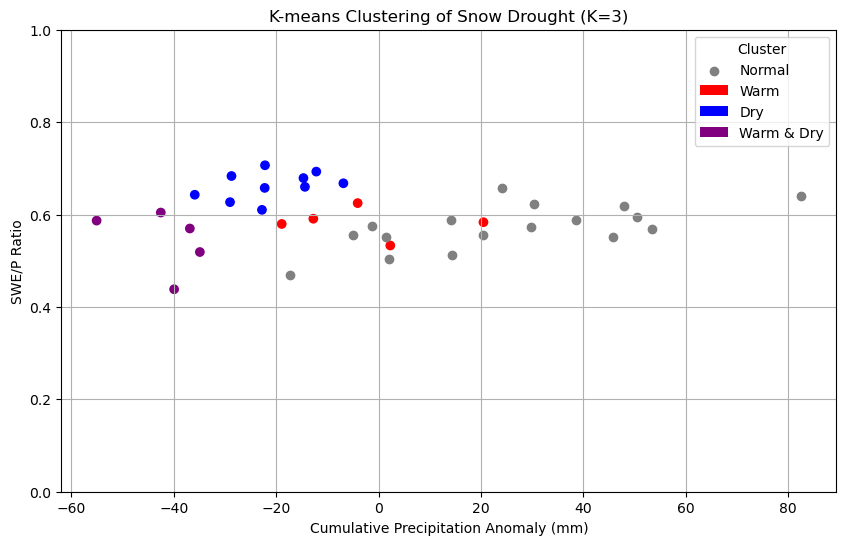

In [345]:
# Assign names to clusters based on their characteristics
cluster_labels = {
    0: 'Warm',        # Replace 0, 1, 2 with the actual cluster numbers after inspection
    1: 'Dry',
    2: 'Warm & Dry'
    
}

# Map cluster numbers to names in the DataFrame
snow_drought_years['cluster_name'] = snow_drought_years['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))

# Define colors for each cluster (adjust colors as needed)
cluster_colors = {'Warm': 'red', 'Dry': 'blue', 'Warm & Dry': 'purple'}

plt.scatter(snow_drought_years['cumulative_P_anomaly'], snow_drought_years['mean_SWE/cumulative_P'], c=snow_drought_years['cluster_name'].map(cluster_colors))
plt.scatter(normal_years['cumulative_P_anomaly'], normal_years['mean_SWE/cumulative_P'], c='grey', label='Normal')
plt.xlabel('Cumulative Precipitation Anomaly (mm)')
plt.ylabel('SWE/P Ratio')
# Create a legend for named clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.title('K-means Clustering of Snow Drought (K=3)')
plt.ylim(0,1)
plt.grid(True)
plt.savefig(output_path + 'K-means Clustering of Seasonal Data (K=3).png')
plt.show()